<a href="https://colab.research.google.com/github/Gr33n34/Apoptotic-density-mapping/blob/main/Jana.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install lifelines

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.5/94.5 kB 5.6 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4031 sha256=3d2d830cc2aa5daa3ac0e2c936280b633c68388eace7d87d19d865fdb0464f20
  Stored in directory: /root/.cache/pip/wheels/25/cc/e0/ef2969164144c899fedb22b338f6703e2b9cf46eeebf254991
Successfully built autograd-gamma


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from google.colab import files
import matplotlib.pyplot as plt
import matplotlib
from scipy import stats
from sklearn import preprocessing
import math
import re
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test

In [3]:
# Loading data
uploaded = files.upload()

Saving OESpy.xlsx to OESpy.xlsx


In [5]:
# Loading results from excel
raw_data = uploaded['OESpy.xlsx']
# Putting data into dataframe
df = pd.read_excel(raw_data)
df.head()

<ipython-input-5-f36af6dd1375>:4: FutureWarning: Passing bytes to 'read_excel' is deprecated and will be removed in a future version. To read from a byte string, wrap it in a `BytesIO` object.
  df = pd.read_excel(raw_data)
/usr/local/lib/python3.10/dist-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


,Anzahl,NR,GENDER,GEBDATUM,Jahr,ALTER,Präf.,E-Nr.,Regr.,Diag.,...,Claudin 6,GATA4 IHC,GATA4 FISH,SMURF1 FISH,CD138 IHC,Claudin 18.2,FOLR1,Apik,TOT1,Survival_Months
0,1,799.0,M,1957-06-01 00:00:00,2010,53.0,AK,9618,2,Adeno,...,0,0.0,0.0,0,0.0,0,0,0,0.0,94.733333
1,2,799.0,M,1957-06-01 00:00:00,2010,53.0,AK,9618,2,Adeno,...,0,1.0,0.0,0,99.0,0,0,0,0.0,94.733333
2,3,NaN,M,1946-08-23 00:00:00,1998,52.0,AK,3610,x,Adeno,...,0,3.0,0.0,0,3.0,0,0,0,0.0,138.433333
3,4,NaN,M,1930-04-14 00:00:00,1998,68.0,AK,8768,x,Adeno,...,0,2.0,0.0,0,2.0,1,0,0,0.0,136.100000
4,5,NaN,M,1926-05-07 00:00:00,1998,72.0,AK,631,x,Adeno,...,0,3.0,2.0,2,0.0,0,0,0,1.0,3.600000


In [7]:
# Loading data
uploaded = files.upload()

Saving TMA_Köln_EAC_240827.xlsx to TMA_Köln_EAC_240827.xlsx


In [17]:
# Loading results from excel
raw_data = uploaded['TMA_Köln_EAC_240827.xlsx']
# Putting data into dataframe
df1 = pd.read_excel(raw_data)
df1.head()

<ipython-input-17-c823df8d3db4>:4: FutureWarning: Passing bytes to 'read_excel' is deprecated and will be removed in a future version. To read from a byte string, wrap it in a `BytesIO` object.
  df1 = pd.read_excel(raw_data)


,Anzahl,NR,Präf.,E-Nr.,Jahr,TMA,Tu,Dys,Lk,Metastase,TMA-Position,TMA-Position.1,Intensität,Quantität,IRSm (Intensität x Quantität),Besonderheit
0,1,799.0,AK,9618,2010,1,1a,NaN,NaN,NaN,a,1,0.0,NaN,0.0,NaN
1,2,799.0,AK,9618,2010,1,NaN,NaN,5b,NaN,a,2,0.0,NaN,0.0,NaN
2,3,NaN,AK,3610,1998,1,1a,NaN,NaN,NaN,a,3,0.0,NaN,0.0,NaN
3,4,NaN,AK,8768,1998,1,1e,NaN,NaN,NaN,a,4,0.0,NaN,0.0,NaN
4,5,NaN,AK,631,1998,1,1b,NaN,NaN,NaN,a,5,2.0,2.0,4.0,NaN


In [18]:
# Merge df1 with df2 to get 'Survival_Months'
df1 = df1.merge(df[['E-Nr.', 'Jahr', 'Survival_Months','TOT1']], on=['E-Nr.', 'Jahr'], how='left')

# Handle missing values if needed
df1['Survival_Months'].fillna(0, inplace=True)
df1['status'] = df1['TOT1']
df1['survival'] = df1['Survival_Months']
print(df1['Survival_Months'].isnull().sum())
df1.head()

0


,Anzahl,NR,Präf.,E-Nr.,Jahr,TMA,Tu,Dys,Lk,Metastase,TMA-Position,TMA-Position.1,Intensität,Quantität,IRSm (Intensität x Quantität),Besonderheit,Survival_Months,TOT1,status,survival
0,1,799.0,AK,9618,2010,1,1a,NaN,NaN,NaN,a,1,0.0,NaN,0.0,NaN,94.733333,0.0,0.0,94.733333
1,1,799.0,AK,9618,2010,1,1a,NaN,NaN,NaN,a,1,0.0,NaN,0.0,NaN,94.733333,0.0,0.0,94.733333
2,2,799.0,AK,9618,2010,1,NaN,NaN,5b,NaN,a,2,0.0,NaN,0.0,NaN,94.733333,0.0,0.0,94.733333
3,2,799.0,AK,9618,2010,1,NaN,NaN,5b,NaN,a,2,0.0,NaN,0.0,NaN,94.733333,0.0,0.0,94.733333
4,3,NaN,AK,3610,1998,1,1a,NaN,NaN,NaN,a,3,0.0,NaN,0.0,NaN,138.433333,0.0,0.0,138.433333


<Axes: xlabel='IRSm (Intensität x Quantität)', ylabel='count'>

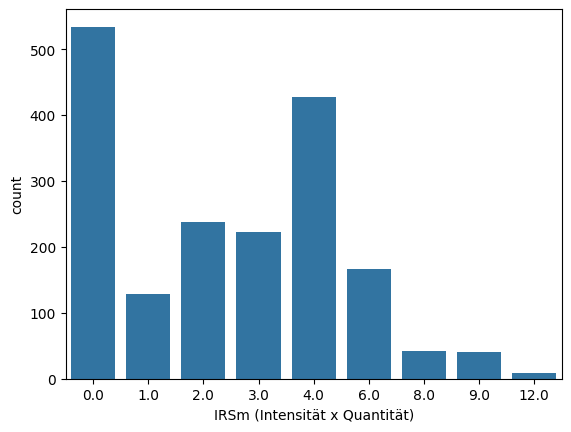

In [13]:
sns.barplot(df1['IRSm (Intensität x Quantität)'].value_counts())

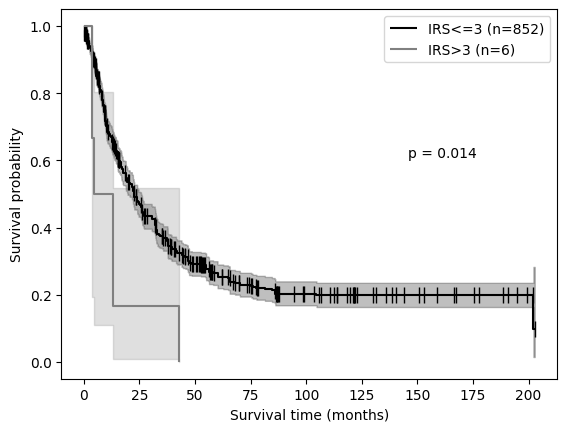

In [32]:
# Select data
group_1 = df1[df1['IRSm (Intensität x Quantität)'] <= 9]
group_2 = df1[df1['IRSm (Intensität x Quantität)'] > 9]

# Remove missing values and select columns
group_1 = group_1[['status', 'survival']].dropna()
group_2 = group_2[['status', 'survival']].dropna()

# Create plot
fig, ax = plt.subplots()

# Initialize Kaplan-Meier model
kmf = KaplanMeierFitter()

# Fit and plot survival curve for group_1
n0 = len(group_1['status'])
kmf.fit(durations=group_1['survival'], event_observed=group_1['status'], label=f'IRS<=3 (n={n0})')
kmf.plot(ax=ax, ci_show=True, show_censors=True, censor_styles={'marker': '|', 'ms': 12}, solid_capstyle='butt', color='black')

# Fit and plot survival curve for group_2
n1 = len(group_2['status'])
kmf.fit(durations=group_2['survival'], event_observed=group_2['status'], label=f'IRS>3 (n={n1})')
kmf.plot(ax=ax, ci_show=True, show_censors=True, censor_styles={'marker': '|', 'ms': 12}, solid_capstyle='butt', color='gray')

# Set axis labels and title
plt.xlabel('Survival time (months)')
plt.ylabel('Survival probability')

# Modify legend
ax.legend()

# Add p-value to plot
output = logrank_test(
    durations_A = group_1['survival'],
    durations_B = group_2['survival'],
    event_observed_A = group_1['status'],
    event_observed_B = group_2['status'])
p_value = output.p_value
ax.text(0.7, 0.6, f'p = {p_value:.3f}', transform=ax.transAxes)
# Display plot
plt.show()
#plt.savefig("Total.png")
#files.download("Total.png")

In [ ]:
£££